In [1]:
from geopy.geocoders import Nominatim

In [2]:
geolocator = Nominatim(user_agent="Test")

In [3]:
# get location raw data
location = geolocator.geocode("Koning Albertstraat 22, 2300 Turnhout").raw
# print raw data
print(location)

{'place_id': 236969605, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 685523862, 'boundingbox': ['51.3276527', '51.3276985', '4.9464252', '4.9477375'], 'lat': '51.327675', 'lon': '4.9471574', 'display_name': 'Koning Albertstraat, Turnhout, Antwerpen, Vlaanderen, 2300, België / Belgique / Belgien', 'class': 'highway', 'type': 'residential', 'importance': 0.5199999999999999}


In [4]:
latitude = location["lat"]
longitude = location["lon"]

In [5]:
print(latitude,longitude)

51.327675 4.9471574


In [6]:
import ogr, osr

pointX = latitude
pointY = 4.4008

# Spatial Reference System
inputEPSG = 4326
outputEPSG = 31370

# create coordinate transformation
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(inputEPSG)

outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(outputEPSG)

coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# create a geometry from coordinates
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(float(latitude), float(longitude))

# transform point
point.Transform(coordTransform)

# print point in EPSG 4326
print(point.GetX(), point.GetY())

190316.96532861446 224365.12736299168


In [7]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:31370')
x1,y1 = latitude,longitude
x2,y2 = transform(inProj,outProj,longitude, latitude)
print(x2,y2)

/home/admin1/anaconda3/envs/python_env/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/admin1/anaconda3/envs/python_env/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_4421/1941886611.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-p

188518.1651129215 225154.27326212171


In [7]:
from osgeo import gdal, osr
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]
    
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    raster = dataset.GetRasterBand(1)
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
#     array[array==int(metadata['noDataValue'])]=np.nan
    array = array/metadata['scaleFactor']
    return array, metadata

In [ ]:
dsarray, metadata  = raster2array("geo-files/DHMVIIDSMRAS1m_k08/GeoTIFF/DHMVIIDSMRAS1m_k08.tif")
# proj = ds.GetProjection()

/tmp/ipykernel_6309/172283554.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)


In [10]:
# dsarray = ds.ReadAsArray()

In [11]:
# maxX = ds.RasterXSize

In [12]:
# maxY = ds.RasterYSize

In [13]:
trans= ds.GetGeoTransform()

In [46]:
trans

(162000.0, 1.0, 0.0, 238000.0, 0.0, -1.0)

In [32]:
pixel_x = (point.GetX() - metadata['ext_dict']['xMin'])/metadata['pixelWidth']
pixel_y = (point.GetY() - metadata['ext_dict']['xMin'])/(metadata['pixelWidth'])

In [33]:
if(pixel_x<metadata['array_cols'] and pixel_y< metadata['array_rows']):
    print("point found in this file")
else:
    print("Not found")

point found in this file


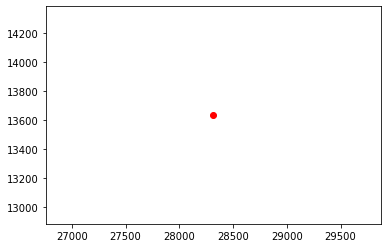

In [34]:
plt.plot ( pixel_x, pixel_y, 'ro')

In [45]:
xMax= round(pixel_x+10)
ymax = round(pixel_y+10)
x_min = round(pixel_x-10)
y_min = round(pixel_y -10)

subset = dsarray[y_min:ymax, x_min:xMax]
print(subset.shape)

(20, 20)


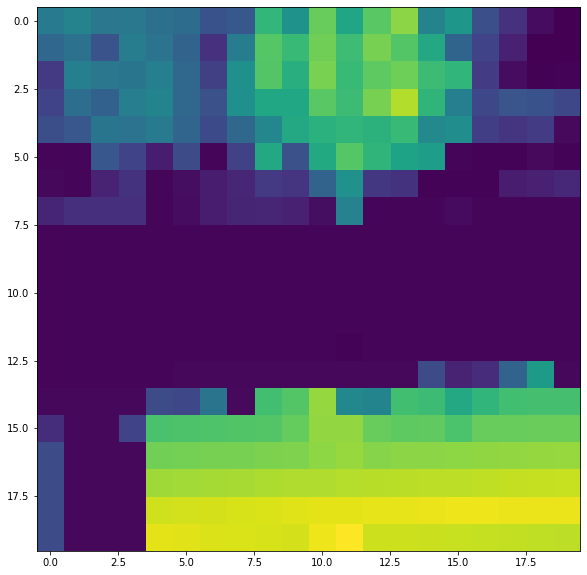

In [42]:
plt.figure(figsize=(20,10))
plt.imshow(subset)

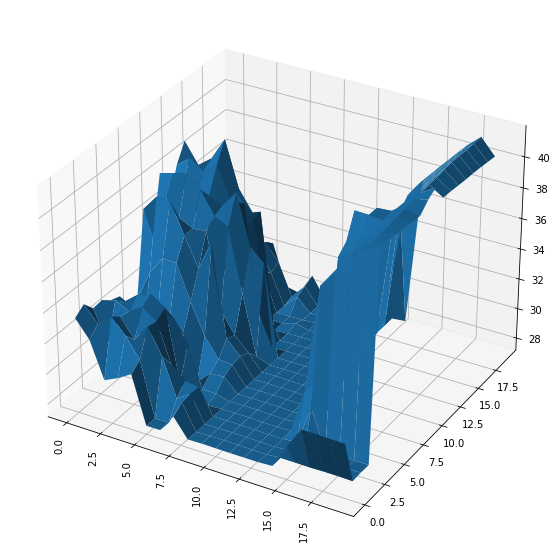

In [44]:
from mpl_toolkits import mplot3d

ny, nx = subset.shape
x = np.arange(0,subset.shape[0])
y = np.arange(0,subset.shape[1])
xv, yv = np.meshgrid(x, y)
z = subset[xv,yv]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
plt.xticks(rotation=90)
dem3d=ax.plot_surface(xv,yv,z)
plt.show()